In [1]:
#Import necessary packages:
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import math
from astropy.io import fits
#import linmix
#import corner

In [2]:
!pwd

/Users/Trevor1/Desktop/git/Cosmology_Quasars/Gordons_Xray_data


In [3]:
import sys
git_path = '/Users/Trevor1/Desktop/git/CIV_Distance/'
sys.path.append(git_path)
from CIVfunctions import project,CIV_distance


#Best-fit line -- this part could be improved
#bestfit = np.load("/Users/gtr/Work/git/CIV_Distance/data/RM_CIV_bestFitLine_noScale.npy")[65000:,:]
#bestfit = np.load("/Users/gtr/Work/git/CIV_Distance/data/bestfit_linear.npy")[65000:,:]
bestfit = np.load(git_path+"data/bestfit.npy")

In [4]:
!pwd

/Users/Trevor1/Desktop/git/Cosmology_Quasars/Gordons_Xray_data


In [5]:
from bokeh.io import output_notebook, output_file, show
from bokeh.plotting import figure
from bokeh.layouts import gridplot, column, row
from bokeh.models import ColumnDataSource, LinearColorMapper, ColorBar, HoverTool
from bokeh.transform import transform
from bokeh.models.widgets import Tabs, Panel

In [6]:
#%%matplotlib inline

#Set color table:
cmap_rainbow=cm.Spectral
cmap_rainbow_r=cm.Spectral_r

sizeTimlin = 60
sizeChandra = 60
sizeSDSSRM = 60
sizeAll = 10

markerTimlin='o'
markerChandra='^'
markerSDSSRM='*'
markerAll = 'o'

#In case this needs to be adjusted later:
figsize_x=8
figsize_y=8

pheight = pwidth = 300
gheight = gwidth = 8

#Legend size
lsize = '6pt'

#Desired whitespace for plot limits
whitespace=0.05

c=2.998*10**5

In [7]:
#Gordon's matplotlib defaults to keep from having to set them for every plot
#and because simply importing richardsplot doesn't seem to work
#Need something like this for Bokeh too.

def figsze(hscale, vscale=0.618034, fig_width_pt = 504.0):
    """Get the fig_width_pt by inserting the textwidth into LaTeX document.
    hscale is fraction of text width you want.
    vscale is fraction of hscale (defaults to golden ratio)  
    """
   
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    fig_width = fig_width_pt*inches_per_pt*hscale   # width in inches
    fig_height = fig_width*vscale                   # height in inches
    fig_size = [fig_width,fig_height]
    return fig_size

pgf_with_latex = {                      # setup matplotlib to use latex for output
    "axes.linewidth":1.1,               # width of box, 2 is too wide, 1 is too narrow
    "pgf.texsystem": "pdflatex",        # change this if using xetex or lautex
    "text.usetex": False,                # use LaTeX to write all text
    "font.family": "serif",
    "font.serif": [],                   # blank entries should cause plots to inherit fonts from the document
    "font.sans-serif": [],
    "font.monospace": [],
    "axes.labelsize": 20,               # LaTeX default is 10pt font, font size of axis text label
    "axes.labelpad" : 6,                # Distance between label and axis    
    "axes.formatter.limits":[-99,99],   # use sci notation if log10 of axis range is smaller than first or larger than second.
                                        # GTR: Actually *don't* -- should change the axis label instead.  E.g., "Flux Density (10^-17 ergs/s/cm^2)" 
                                        # This is a hack b/c there doesn't seem to be an rcParams version of
                                        # axes.ticklabel_format(style='plain')
    #"axes.formatter.style":"plain",    # Turn off multiplicative offsets (sci notation) to the axes [GTR: Doesn't work]
    "axes.formatter.useoffset":False,   # Turn off additive offsets to the axes
    "font.size": 20,
    "legend.fontsize": 18,              # Make the legend/label fonts a little smaller
    "xtick.labelsize": 20,              # Font size of numbers 
    "ytick.labelsize": 20,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.minor.visible": True,
    "ytick.minor.visible": True,
    'xtick.major.width':1.0, 
    'xtick.minor.width':1.0, 
    'ytick.major.width':1.0, 
    'ytick.minor.width':1.0, 
    'xtick.major.size':8,             # size of tickmarks in points
    'xtick.minor.size':4, 
    'ytick.major.size':8, 
    'ytick.minor.size':4,
    'xtick.major.pad':8,               # distance between box and numbers
    'ytick.major.pad':8,
    "figure.figsize": figsze(1,1),     # default fig size of 0.9 textwidth
    "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts because your computer can handle it
        r"\usepackage[T1]{fontenc}",        # plots will be generated using this preamble
        ]
    }

mpl.rcParams.update(pgf_with_latex)

import palettable
#csPRGn = palettable.colorbrewer.sequential.PRGn_8.mpl_colors
csPRGn = ['#1b7837', '#5aae61', '#a6dba0', '#c2a5cf', '#9970ab', '#762a83']
csPUOr = ['#b35806', '#e08214', '#fdb863', '#b2abd2', '#8073ac', '#542788'] 
#csDark = palettable.colorbrewer.sequential.PRGn_8.mpl_colors

/opt/anaconda3/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


Let's read in the Timlin file with Amy Rankine's CIV values and merge that with the Shen+11 catalog file.

Ideally we do this based on coordinates, but since we have SDSS Name in both we can use that instead since it is a bit easier (though could miss a few objects if the names were "computed" incorrectly).

In [8]:
#Read in necessary data:
#hduAllXray = fits.open('AllXRayDataSensCut.fits') 

#Use "with" syntax for better memory handling
#with fits.open('./AllXRayDataSensCut.fits') as hduAllXray:
#with fits.open('/home/angelica/Research/Paper3/AllXRayDataSensCut.fits') as hduAllXray:
#    headerAllXray = hduAllXray[0].header
#    dataAllXray = hduAllXray[1].data
#    hduAllXray.close()
    
#with fits.open('/home/angelica/Research/Paper3/AllXRayParams_wPerpCIV.fits') as hduAllXray:    
with fits.open('./AllXRayData.fits') as hduAllXray:
    headerAllXray = hduAllXray[0].header
    dataAllXray = hduAllXray[1].data
    hduAllXray.close()

dfAllXray=dataAllXray  
    
#Convert numpy arrays to Pandas dataframe
#dfAllXray = pd.DataFrame(dataAllXray)

#Fix the fact that some L2500 values are logged and others are not
#dfAllXray.loc[dfAllXray.L2500>100, 'L2500'] = np.log10(dfAllXray.loc[dfAllXray.L2500>100, 'L2500'])

#Fix the missing L/LEdd values
#dfAllXray.loc[dfAllXray.LOGEDD_RATIO<-90, 'LOGEDD_RATIO'] = np.nan

#Fix the missing HeII values
#dfAllXray.loc[dfAllXray['HeII EQW']<=0, 'HeII EQW'] = np.nan

#dfAllXray.head()

In [9]:
print(len(dfAllXray))

5682


Make Blueshift plots with Bokeh

There are 4 examples, each adding a level of complexity, so that it is somewhat easier to see what is happening.

I'm sure that there is a way to reduce the number of lines of code by changing the defaults, but I haven't figured that out yet.

Commented out the first 3 since they don't work with the new data file, but they are here for reference.

In [10]:
#Define the subsets.  These all will have separate legend entries

mask1a = ((dfAllXray['Data_source']==1)&(dfAllXray['Clean']==True)) #Timlin+20; sensitive sample
mask1b = ((dfAllXray['Data_source']==1)&(dfAllXray['Clean']==False)) #Timlin+20; remainder of sample
mask2 = (dfAllXray['Data_source']==2) #Our HST/Chandra
mask3 = (dfAllXray['Data_source']==3) #SDSS-RM
mask4a = ((dfAllXray['Data_source']==4)&(dfAllXray['Clean']==True)) #Lusso+20; clean sample
mask4b = ((dfAllXray['Data_source']==4)&(dfAllXray['Clean']==False)) #Lusso+20; remainder
mask4c  = ((dfAllXray['Data_source']==4)&(dfAllXray['Nardini_Sample']==True)) #Nardini+19 (subset of Lusso+20)

In [11]:
#Example with Linked plots, Tabs, and Subsamples

#y = dfAllXray['CIV Blueshift']
Name = dfAllXray['SDSS']

#y = np.log10(dfAllXray['CIV_EW'])

x1 = dfAllXray['L2500']
#x2 = dfAllXray['CIV EQW']
x2 = dfAllXray['Delta_Alpha_ox']
x3 = np.log10(dfAllXray['HeII EQW'])
x4 = dfAllXray['Alpha_ox']
x5 = dfAllXray['CIV_blue']
x6 = dfAllXray['CIV_EW']
logx6 = np.log10(dfAllXray['CIV_EW'])
x7 = dfAllXray['Gamma']
#x8 = dfAllXray['LOGBH']  #Put this back in later
x9 = dfAllXray['Delg-i']

<ipython-input-11-ea2d2ba4469b>:11: RuntimeWarning: invalid value encountered in log10
  x3 = np.log10(dfAllXray['HeII EQW'])


In [12]:
print(min(x5),max(x5),min(x6),max(x6))

-2585.612245627227 6166.797081979803 5.622421055642074 426.04393342206424


In [13]:
#Compute CIV distance
ew = x6
logEW = logx6
blue = x5

c4data = np.array([blue, ew]).T
c4dist, c4dist_perp = CIV_distance(c4data, bestfit, step=10, logEW=False, path=git_path, perp_dist=True) #compute CIV distances like this
print("Done linear")

c4data_log = np.array([blue, logEW]).T
c4dist_log, c4dist_log_perp = CIV_distance(c4data_log, bestfit, step=10, path=git_path, perp_dist=True)
print("Done log")

Done linear
Done log


In [14]:
#x8, y = c4dist_perp, c4dist
x8, y = c4dist_log_perp, c4dist_log

In [15]:
len(dfAllXray), len(c4dist_log)

(5682, 5682)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


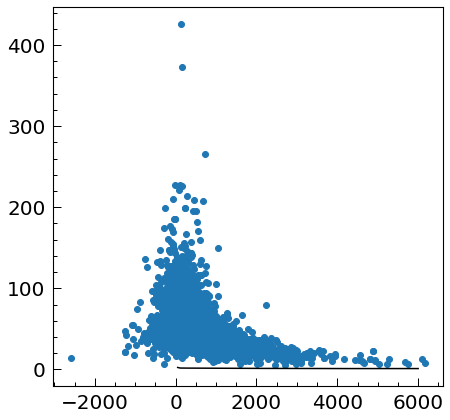

In [16]:
plt.scatter(c4data[:,0], c4data[:,1])
plt.plot(bestfit[:,0], bestfit[:,1], "k")

In [17]:
bestfit

array([[4.99670397e+01, 2.50000000e+00],
       [4.99703733e+01, 2.49995200e+00],
       [4.99737069e+01, 2.49990399e+00],
       ...,
       [5.99954994e+03, 1.11663534e+00],
       [5.99977497e+03, 1.11663511e+00],
       [6.00000000e+03, 1.11663489e+00]])

In [18]:
import joblib

bestfit_lin = bestfit.copy()
bestfit_lin[:,1] = 10.**bestfit_lin[:,1]
scaler_lin = joblib.load("../scalers/scaler_linEW.save")
c4data_lin_scale = scaler_lin.transform(c4data)
bestfit_lin_scale = scaler_lin.transform(bestfit_lin)

scaler_log = joblib.load("../scalers/scaler_logEW.save")
c4data_log_scale = scaler_log.transform(c4data_log)
bestfit_log_scale = scaler_log.transform(bestfit)

In [19]:
#Load in Amy's data to compare scaling
c4data_lin_scale_amy = np.load("CIV_amy_scaled_linear.npy")
c4data_log_scale_amy = np.load("CIV_amy_scaled_log.npy")

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


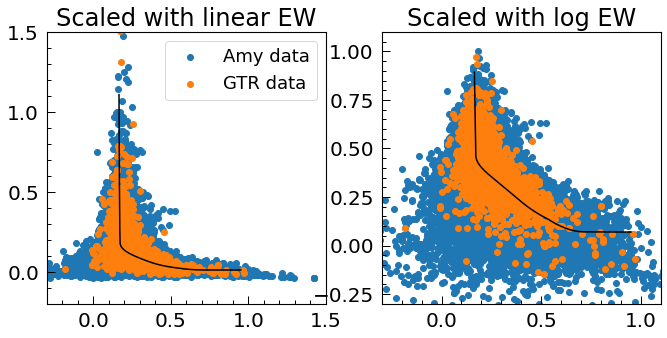

In [20]:
#See what the scaled data look like
fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(11,5))

ax1.scatter(c4data_lin_scale_amy[:,0], c4data_lin_scale_amy[:,1], label="Amy data")
ax1.scatter(c4data_lin_scale[:,0], c4data_lin_scale[:,1], label="GTR data")
ax1.plot(bestfit_lin_scale[:,0], bestfit_lin_scale[:,1], "-k")
ax1.set_xlim(-0.3, 1.5)
ax1.set_ylim(-0.2, 1.5)
ax1.set_title("Scaled with linear EW")
ax1.legend(loc="best")

ax2.scatter(c4data_log_scale_amy[:,0], c4data_log_scale_amy[:,1])
ax2.scatter(c4data_log_scale[:,0], c4data_log_scale[:,1])
ax2.plot(bestfit_log_scale[:,0], bestfit_log_scale[:,1], "-k")
ax2.set_xlim(-0.3, 1.1)
ax2.set_ylim(-0.3, 1.1)
ax2.set_title("Scaled with log EW")

plt.show()

In [21]:
print(len(x8))

5682


In [22]:
#dfAllXray['RMID_1'] = '000'

sizeAll=3

#xmin=np.nanmin(x)
#xmax=np.nanmax(x)
#xrange=xmax-xmin
#xlims=[xmin-whitespace*xrange,xmax+whitespace*xrange]

#ymin=np.nanmin(y)
#ymax=np.nanmax(y)
#yrange=ymax-ymin
#ylims=[ymin-whitespace*yrange,ymax+whitespace*yrange]

# create a column data source for the plots to share
source1a = ColumnDataSource(data=dict(y=y[mask1a], x1=x1[mask1a], x2=x2[mask1a], x3=x3[mask1a], x4=x4[mask1a], \
                                     x5=x5[mask1a], x6=x6[mask1a], logx6=logx6[mask1a], x7=x7[mask1a], x8=x8[mask1a], x9=x9[mask1a],\
                                    z=dfAllXray['Redshifts'][mask1a]))

source1b = ColumnDataSource(data=dict(y=y[mask1b], x1=x1[mask1b], x2=x2[mask1b], x3=x3[mask1b], x4=x4[mask1b], \
                                     x5=x5[mask1b], x6=x6[mask1b], logx6=logx6[mask1b], x7=x7[mask1b], x8=x8[mask1b], x9=x9[mask1b],\
                                    z=dfAllXray['Redshifts'][mask1b]))

source2 = ColumnDataSource(data=dict(y=y[mask2], x1=x1[mask2], x2=x2[mask2], x3=x3[mask2], x4=x4[mask2], \
                                     x5=x5[mask2], x6=x6[mask2], logx6=logx6[mask2], x7=x7[mask2], x8=x8[mask2], x9=x9[mask2],\
                                    z=dfAllXray['Redshifts'][mask2]))

source3 = ColumnDataSource(data=dict(y=y[mask3], x1=x1[mask3], x2=x2[mask3], x3=x3[mask3], x4=x4[mask3], \
                                     x5=x5[mask3], x6=x6[mask3], logx6=logx6[mask3], x7=x7[mask3], x8=x8[mask3], x9=x9[mask3],\
                                    z=dfAllXray['Redshifts'][mask3]))

source4a = ColumnDataSource(data=dict(y=y[mask4a], x1=x1[mask4a], x2=x2[mask4a], x3=x3[mask4a], x4=x4[mask4a], \
                                     x5=x5[mask4a], x6=x6[mask4a], logx6=logx6[mask4a], x7=x7[mask4a], x8=x8[mask4a], x9=x9[mask4a],\
                                    z=dfAllXray['Redshifts'][mask4a]))

source4b = ColumnDataSource(data=dict(y=y[mask4b], x1=x1[mask4b], x2=x2[mask4b], x3=x3[mask4b], x4=x4[mask4b], \
                                     x5=x5[mask4b], x6=x6[mask4b], logx6=logx6[mask4b], x7=x7[mask4b], x8=x8[mask4b], x9=x9[mask4b],\
                                    z=dfAllXray['Redshifts'][mask4b]))

source4c = ColumnDataSource(data=dict(y=y[mask4c], x1=x1[mask4c], x2=x2[mask4c], x3=x3[mask4c], x4=x4[mask4c], \
                                     x5=x5[mask4c], x6=x6[mask4c], logx6=logx6[mask4c], x7=x7[mask4c], x8=x8[mask4c], x9=x9[mask4c],\
                                    z=dfAllXray['Redshifts'][mask4c]))

TOOLS = "box_select,lasso_select,pan,wheel_zoom,box_zoom,hover,reset,help"

#TOOLTIPS=[
#            ('RMID', '@RMID'),
#            ('z', '@z')
#            ]

TOOLTIPS=[
            ('SDSS', '@Name'),
            ('z', '@z')
            ]

color_mapper = LinearColorMapper(palette="Viridis256", low=x1.min(), high=x1.max())
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=12, location=(0,0), title='L2500')

In [23]:
#legend_label="Sample3",

# create a new plot
p1 = figure(width=pwidth, plot_height=pheight, tools=TOOLS, tooltips=TOOLTIPS)#, y_range=(-1500,6500))
p1.circle('x5', 'y', source=source1a, legend_label='Timlin Sensitive', size=sizeAll, color="navy", alpha=0.5, selection_color="orange")
p1.circle('x5', 'y', source=source1b, legend_label='Timlin Other', size=sizeAll, color="navy", alpha=0.5, selection_color="orange")
p1.circle('x5', 'y', source=source4a, legend_label='Lusso Clean', size=sizeAll, color="navy", alpha=0.5, selection_color="orange")
p1.circle('x5', 'y', source=source4b, legend_label='Lusso Other', size=sizeAll, color="navy", alpha=0.5, selection_color="orange")
p1.circle('x5', 'y', source=source2, legend_label='SDSSRM', size=sizeAll, color="navy", alpha=0.5, selection_color="orange")
p1.circle('x5', 'y', source=source3, legend_label='Chandra/HST', size=sizeAll, color="navy", alpha=0.5, selection_color="orange")
p1.circle('x5', 'y', source=source4c, legend_label='Nardini', size=sizeAll, color="navy", alpha=0.5, selection_color="orange")
p1.yaxis.axis_label = 'CIV Distance'
p1.xaxis.axis_label = 'Blueshift'
p1.legend.click_policy="hide"
p1.legend.label_text_font_size = lsize
p1.legend.glyph_height = gheight
p1.legend.location = 'top_left'
p1.legend.spacing = 1

p2 = figure(width=pwidth, plot_height=pheight, tools=TOOLS, tooltips=TOOLTIPS)#, y_range=(-1500,6500))
p2.circle('x6', 'y', source=source1a, legend_label='Timlin Sensitive', size=sizeAll, color="navy", alpha=0.5, selection_color="orange")
p2.circle('x6', 'y', source=source1b, legend_label='Timlin Other', size=sizeAll, color="navy", alpha=0.5, selection_color="orange")
p2.circle('x6', 'y', source=source4a, legend_label='Lusso Clean', size=sizeAll, color="navy", alpha=0.5, selection_color="orange")
p2.circle('x6', 'y', source=source4b, legend_label='Lusso Other', size=sizeAll, color="navy", alpha=0.5, selection_color="orange")
p2.circle('x6', 'y', source=source2, legend_label='SDSSRM', size=sizeAll, color="navy", alpha=0.5, selection_color="orange")
p2.circle('x6', 'y', source=source3, legend_label='Chandra/HST', size=sizeAll, color="navy", alpha=0.5, selection_color="orange")
p2.circle('x6', 'y', source=source4c, legend_label='Nardini', size=sizeAll, color="navy", alpha=0.5, selection_color="orange")
p2.yaxis.axis_label = 'CIV Distance'
p2.xaxis.axis_label = 'log(CIV EQW)'
p2.legend.click_policy="hide"
p2.legend.label_text_font_size = lsize
p2.legend.glyph_height = gheight
p2.legend.location = 'top_right'
p2.legend.spacing = 1

p3 = figure(width=pwidth, plot_height=pheight, tools=TOOLS, tooltips=TOOLTIPS)#, y_range=(-1500,6500))
p3.circle('x3', 'y', source=source1a, legend_label='Timlin Sensitive', size=sizeAll, color="navy", alpha=0.5, selection_color="orange")
p3.circle('x3', 'y', source=source1b, legend_label='Timlin Other', size=sizeAll, color="navy", alpha=0.5, selection_color="orange")
p3.circle('x3', 'y', source=source4a, legend_label='Lusso Clean', size=sizeAll, color="navy", alpha=0.5, selection_color="orange")
p3.circle('x3', 'y', source=source4b, legend_label='Lusso Other', size=sizeAll, color="navy", alpha=0.5, selection_color="orange")
p3.circle('x3', 'y', source=source2, legend_label='SDSSRM', size=sizeAll, color="navy", alpha=0.5, selection_color="orange")
p3.circle('x3', 'y', source=source3, legend_label='Chandra/HST', size=sizeAll, color="navy", alpha=0.5, selection_color="orange")
p3.circle('x3', 'y', source=source4c, legend_label='Nardini', size=sizeAll, color="navy", alpha=0.5, selection_color="orange")
p3.yaxis.axis_label = 'CIV Distance'
p3.xaxis.axis_label = 'log(HeII EQW)'
p3.legend.click_policy="hide"
p3.legend.label_text_font_size = lsize
p3.legend.glyph_height = gheight
p3.legend.location = 'top_right'
p3.legend.spacing = 1

#selection_glyph = Circle(fill_color='orange', line_color=None)
#nonselection_glyph = Circle(fill_color='#1f77b4', fill_alpha=0.1, line_color=None)
#r1.selection_glyph = selection_glyph
#r1.nonselection_glyph = nonselection_glyph



p4 = figure(width=pwidth, plot_height=pheight, tools=TOOLS, tooltips=TOOLTIPS, y_range=(29,33))#, x_range=(0.5, -0.5), y_range=(-1500,6500))
p4.circle('y', 'x1', source=source1a, legend_label='Timlin Sensitive', size=sizeAll, color="navy", alpha=0.5, selection_color="orange")
p4.circle('y', 'x1', source=source1b, legend_label='Timlin Other', size=sizeAll, color="navy", alpha=0.5, selection_color="orange")
p4.circle('y', 'x1', source=source4a, legend_label='Lusso Clean', size=sizeAll, color="navy", alpha=0.5, selection_color="orange")
p4.circle('y', 'x1', source=source4b, legend_label='Lusso Other', size=sizeAll, color="navy", alpha=0.5, selection_color="orange")
p4.circle('y', 'x1', source=source2, legend_label='SDSSRM', size=sizeAll, color="navy", alpha=0.5, selection_color="orange")
p4.circle('y', 'x1', source=source3, legend_label='Chandra/HST', size=sizeAll, color="navy", alpha=0.5, selection_color="orange")
p4.circle('y', 'x1', source=source4c, legend_label='Nardini', size=sizeAll, color="navy", alpha=0.5, selection_color="orange")
p4.xaxis.axis_label = 'CIV Distance'
p4.yaxis.axis_label = 'L_{2500}'
#p6.x_range.flipped = True
p4.legend.click_policy="hide"
p4.legend.label_text_font_size = "6pt"
p4.legend.glyph_height = gheight
p4.legend.location = 'top_left'
p4.legend.spacing = 1

p5 = figure(width=pwidth, plot_height=pheight, tools=TOOLS, tooltips=TOOLTIPS, y_range=(29,33))# x_range=(-2.3,-0.9))#, y_range=(-1500,6500))
p5.circle('x5', 'x1', source=source1a, legend_label='Timlin Sensitive', size=sizeAll, color="navy", alpha=0.5, selection_color="orange")
p5.circle('x5', 'x1', source=source1b, legend_label='Timlin Other', size=sizeAll, color="navy", alpha=0.5, selection_color="orange")
p5.circle('x5', 'x1', source=source4a, legend_label='Lusso Clean', size=sizeAll, color="navy", alpha=0.5, selection_color="orange")
p5.circle('x5', 'x1', source=source4b, legend_label='Lusso Other', size=sizeAll, color="navy", alpha=0.5, selection_color="orange")
p5.circle('x5', 'x1', source=source2, legend_label='SDSSRM', size=sizeAll, color="navy", alpha=0.5, selection_color="orange")
p5.circle('x5', 'x1', source=source3, legend_label='Chandra/HST', size=sizeAll, color="navy", alpha=0.5, selection_color="orange")
p5.circle('x5', 'x1', source=source4c, legend_label='Nardini', size=sizeAll, color="navy", alpha=0.5, selection_color="orange")
p5.xaxis.axis_label = 'CIV Blueshift'
p5.yaxis.axis_label = 'L_{2500}'
#p5.x_range.flipped = True
p5.legend.click_policy="hide"
p5.legend.label_text_font_size = "6pt"
p5.legend.glyph_height = gheight
p5.legend.location = 'top_left'
p5.legend.spacing = 1

p6 = figure(width=pwidth, plot_height=pheight, tools=TOOLS, tooltips=TOOLTIPS, y_range=(29,33))#, x_range=(0.5, -0.7))#, y_range=(-1500,6500))
p6.circle('x6', 'x1', source=source1a, legend_label='Timlin Sensitive', size=sizeAll, color="navy", alpha=0.5, selection_color="orange")
p6.circle('x6', 'x1', source=source1b, legend_label='Timlin Other', size=sizeAll, color="navy", alpha=0.5, selection_color="orange")
p6.circle('x6', 'x1', source=source4a, legend_label='Lusso Clean', size=sizeAll, color="navy", alpha=0.5, selection_color="orange")
p6.circle('x6', 'x1', source=source4b, legend_label='Lusso Other', size=sizeAll, color="navy", alpha=0.5, selection_color="orange")
p6.circle('x6', 'x1', source=source2, legend_label='SDSSRM', size=sizeAll, color="navy", alpha=0.5, selection_color="orange")
p6.circle('x6', 'x1', source=source3, legend_label='Chandra/HST', size=sizeAll, color="navy", alpha=0.5, selection_color="orange")
p6.circle('x6', 'x1', source=source4c, legend_label='Nardini', size=sizeAll, color="navy", alpha=0.5, selection_color="orange")
p6.xaxis.axis_label = 'CIV EW'
p6.yaxis.axis_label = 'L_{2500}'
#p5.x_range.flipped = True
p6.legend.click_policy="hide"
p6.legend.label_text_font_size = "6pt"
p6.legend.glyph_height = gheight
p6.legend.location = 'top_right'
p6.legend.spacing = 1


p7 = figure(width=pwidth, plot_height=pheight, tools=TOOLS, tooltips=TOOLTIPS)#, y_range=(-1500,6500))
p7.circle('x6', 'x3', source=source1a, legend_label='Timlin', size=sizeAll, color="navy", alpha=0.5, selection_color="orange")
p7.circle('x6', 'x3', source=source2, legend_label='SDSSRM', size=sizeAll, color="navy", alpha=0.5, selection_color="orange")
#p7.circle('x7', 'x3', source=source3, legend='Chandra/HST', size=sizeAll, color="navy", alpha=0.5, selection_color="orange")
p7.xaxis.axis_label = 'CIV Dist'
p7.yaxis.axis_label = 'log(HeII)'
p7.legend.click_policy="hide"
p7.legend.label_text_font_size = "6pt"
p7.legend.glyph_height = gheight

p8 = figure(width=pwidth, plot_height=pheight, tools=TOOLS, tooltips=TOOLTIPS)#, x_range=(-1.7, 0.6))#, y_range=(-1500,6500))
p8.circle('y', 'x8', source=source1a, legend_label='Timlin', size=sizeAll, color="navy", alpha=0.5, selection_color="orange")
p8.circle('y', 'x8', source=source2, legend_label='SDSSRM', size=sizeAll, color="navy", alpha=0.5, selection_color="orange")
#p8.circle('x2', 'x3', source=source3, legend='Chandra/HST', size=sizeAll, color="navy", alpha=0.5, selection_color="orange")
p8.xaxis.axis_label = 'CIV Distance'
p8.yaxis.axis_label = 'CIV Perp Dist'
p8.legend.click_policy="hide"
p8.legend.label_text_font_size = "6pt"
p8.legend.glyph_height = gheight

# create a new plot for 2nd tab
p9 = figure(width=pwidth, plot_height=pheight, tools=TOOLS, tooltips=TOOLTIPS)#, x_range=(230,-1))#, y_range=(29.2,32.5))
p9.circle('x4', 'x1', source=source1a, legend_label='Timlin', size=sizeAll, color="navy", alpha=0.5, selection_color="orange")
p9.circle('x4', 'x1', source=source2, legend_label='SDSSRM', size=sizeAll, color="navy", alpha=0.5, selection_color="orange")
#p9.circle('x4', 'x1', source=source3, legend='Chandra/HST', size=sizeAll, color="navy", alpha=0.5, selection_color="orange")
p9.xaxis.axis_label = 'alpha_ox'
p9.yaxis.axis_label = 'L_2500'
p9.legend.click_policy="hide"
p9.legend.label_text_font_size = "6pt"
p9.legend.glyph_height = gheight
p9.legend.location = 'top_left'

p10 = figure(width=pwidth, plot_height=pheight, tools=TOOLS, tooltips=TOOLTIPS)#, x_range=(-2.3,-0.9))#, y_range=(29.2,32.5))
p10.circle('x5', 'logx6', source=source1a, legend_label='Timlin Sensitive', size=sizeAll, color="navy", alpha=0.5, selection_color="orange")
p10.circle('x5', 'logx6', source=source1b, legend_label='Timlin Other', size=sizeAll, color="navy", alpha=0.5, selection_color="orange")
p10.circle('x5', 'logx6', source=source4a, legend_label='Lusso Clean', size=sizeAll, color="navy", alpha=0.5, selection_color="orange")
p10.circle('x5', 'logx6', source=source4b, legend_label='Lusso Other', size=sizeAll, color="navy", alpha=0.5, selection_color="orange")
p10.circle('x5', 'logx6', source=source2, legend_label='SDSSRM', size=sizeAll, color="navy", alpha=0.5, selection_color="orange")
p10.circle('x5', 'logx6', source=source3, legend_label='Chandra/HST', size=sizeAll, color="navy", alpha=0.5, selection_color="orange")
p10.circle('x5', 'logx6', source=source4c, legend_label='Nardini', size=sizeAll, color="navy", alpha=0.5, selection_color="orange")
#p10.circle('x5', 'y', source=source3, legend='Chandra/HST', size=sizeAll, color="navy", alpha=0.5, selection_color="orange")
p10.line(bestfit[:,0], bestfit[:,1], color="black")
p10.xaxis.axis_label = 'CIV Blueshift'
p10.yaxis.axis_label = 'log(CIV EQW)'
p10.legend.click_policy="hide"
p10.legend.label_text_font_size = "6pt"
p10.legend.glyph_height = gheight

# put all the plots in a gridplot
p = gridplot([[p1, p2, p3], [p4, p5, p6], [p10, p7, p8] ], sizing_mode='scale_width')

tab1 = Panel(child = p, title = 'Tab One')





p11 = figure(width=pwidth, plot_height=pheight, tools=TOOLS, tooltips=TOOLTIPS)#, x_range=(0.5, -0.5))#, y_range=(29.2,32.5))
p11.circle('x5', 'x3', source=source1a, legend_label='Timlin', size=sizeAll, color="navy", alpha=0.5, selection_color="orange")
p11.circle('x5', 'x3', source=source2, legend_label='SDSSRM', size=sizeAll, color="navy", alpha=0.5, selection_color="orange")
#p11.circle('x5', 'x3', source=source3, legend='Chandra/HST', size=sizeAll, color="navy", alpha=0.5, selection_color="orange")
p11.xaxis.axis_label = 'CIV Blueshift)'
p11.yaxis.axis_label = 'log(He II EQW)'
p11.legend.click_policy="hide"
p11.legend.label_text_font_size = "6pt"
p11.legend.glyph_height = gheight
 
p12 = figure(width=pwidth, plot_height=pheight, tools=TOOLS, tooltips=TOOLTIPS)#, x_range=(-1.7, 0.6))#, y_range=(29.2,32.5))
p12.circle('x2', 'x7', source=source1a,legend_label='Timlin', size=sizeAll, color="navy", alpha=0.5, selection_color="orange")
p12.circle('x2', 'x7', source=source2, legend_label='SDSSRM', size=sizeAll, color="navy", alpha=0.5, selection_color="orange")
#p12.circle('x2', 'x7', source=source3, legend='Chandra/HST', size=sizeAll, color="navy", alpha=0.5, selection_color="orange")
p12.xaxis.axis_label = 'Delta_alpha_ox'
p12.yaxis.axis_label = 'Gamma'
p12.legend.click_policy="hide"
p12.legend.label_text_font_size = "6pt"
p12.legend.glyph_height = gheight
p12.legend.location = 'top_left'


tab2 = Panel(child = row(p9,p10,p11,p12), title = 'Tab Two')

#Feed the tabs into a Tabs object

ptabs = Tabs(tabs = [tab1, tab2])

output_file('CIVDistBokehGTR.html')

# show the results
show(ptabs)